In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!git clone https://github.com/hj56775/dlibforbeauty.git

Cloning into 'dlibforbeauty'...


[[260 337]] [[353 334]]


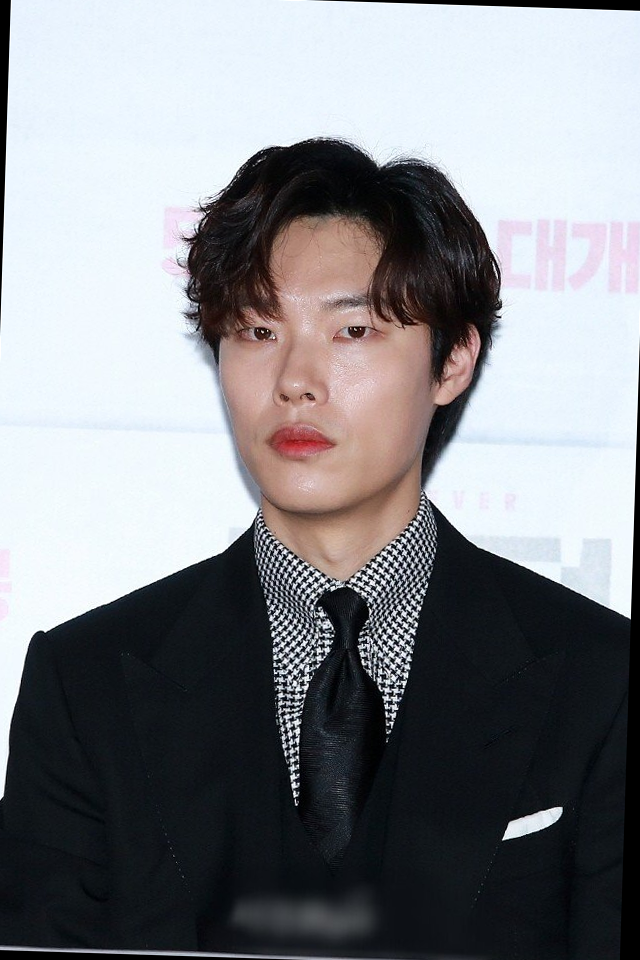

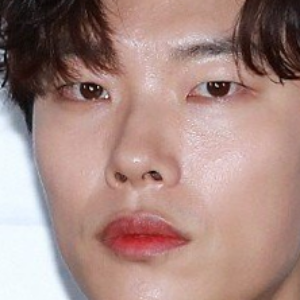

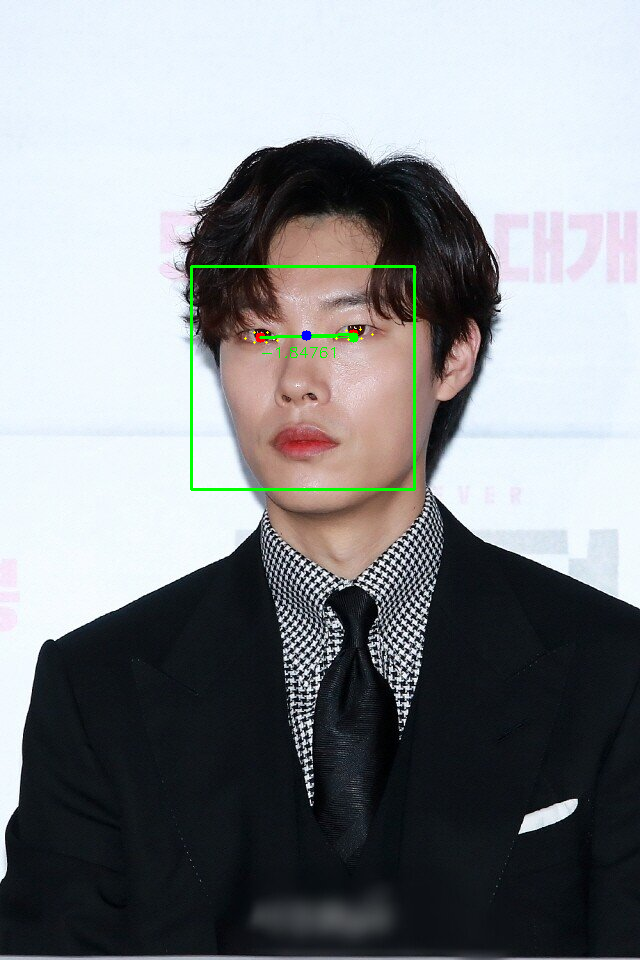

In [4]:
import numpy as np
import dlib
import cv2
from google.colab.patches import cv2_imshow

RIGHT_EYE = list(range(36, 42))
LEFT_EYE = list(range(42, 48))
EYES = list(range(36, 48))

predictor_file = '/content/drive/MyDrive/dlib/model/shape_predictor_68_face_landmarks.dat'
image_file = '/content/drive/MyDrive/dlib/image/0ee7235fab5267e1581d95d4556824e3.jpeg'
MARGIN_RATIO = 1.5
OUTPUT_SIZE = (300, 300)


detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_file)

image = cv2.imread(image_file)
image_origin = image.copy()

(image_height, image_width) = image.shape[:2]
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

rects = detector(gray, 1)

def getFaceDimension(rect):
    return (rect.left(), rect.top(), rect.right() - rect.left(), rect.bottom() - rect.top())

def getCropDimension(rect, center):
    width = (rect.right() - rect.left())
    half_width = width // 2
    (centerX, centerY) = center
    startX = centerX - half_width
    endX = centerX + half_width
    startY = rect.top()
    endY = rect.bottom() 
    return (startX, endX, startY, endY)    

for (i, rect) in enumerate(rects):
    (x, y, w, h) = getFaceDimension(rect)
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    points = np.matrix([[p.x, p.y] for p in predictor(gray, rect).parts()])
    show_parts = points[EYES]

    right_eye_center = np.mean(points[RIGHT_EYE], axis = 0).astype("int")
    left_eye_center = np.mean(points[LEFT_EYE], axis = 0).astype("int")
    print(right_eye_center, left_eye_center)
 
    cv2.circle(image, (right_eye_center[0,0], right_eye_center[0,1]), 5, (0, 0, 255), -1)
    cv2.circle(image, (left_eye_center[0,0], left_eye_center[0,1]), 5, (0, 0, 255), -1)
    
    cv2.circle(image, (left_eye_center[0,0], right_eye_center[0,1]), 5, (0, 255, 0), -1)
    
    cv2.line(image, (right_eye_center[0,0], right_eye_center[0,1]),
             (left_eye_center[0,0], left_eye_center[0,1]), (0, 255, 0), 2)
    cv2.line(image, (right_eye_center[0,0], right_eye_center[0,1]),
         (left_eye_center[0,0], right_eye_center[0,1]), (0, 255, 0), 1)
    cv2.line(image, (left_eye_center[0,0], right_eye_center[0,1]),
         (left_eye_center[0,0], left_eye_center[0,1]), (0, 255, 0), 1)

    eye_delta_x = right_eye_center[0,0] - left_eye_center[0,0]
    eye_delta_y = right_eye_center[0,1] - left_eye_center[0,1]
    degree = np.degrees(np.arctan2(eye_delta_y,eye_delta_x)) - 180

    eye_distance = np.sqrt((eye_delta_x ** 2) + (eye_delta_y ** 2))
    aligned_eye_distance = left_eye_center[0,0] - right_eye_center[0,0]
    scale = aligned_eye_distance / eye_distance

    eyes_center = ((left_eye_center[0,0] + right_eye_center[0,0]) // 2,
            (left_eye_center[0,1] + right_eye_center[0,1]) // 2)
    cv2.circle(image, eyes_center, 5, (255, 0, 0), -1)
            
    metrix = cv2.getRotationMatrix2D(eyes_center, degree, scale)
    cv2.putText(image, "{:.5f}".format(degree), (right_eye_center[0,0], right_eye_center[0,1] + 20),
     	 cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    warped = cv2.warpAffine(image_origin, metrix, (image_width, image_height),
        flags=cv2.INTER_CUBIC)
    
    cv2_imshow(warped)
    (startX, endX, startY, endY) = getCropDimension(rect, eyes_center)
    croped = warped[startY:endY, startX:endX]
    output = cv2.resize(croped, OUTPUT_SIZE)
    cv2_imshow(output)

    for (i, point) in enumerate(show_parts):
        x = point[0,0]
        y = point[0,1]
        cv2.circle(image, (x, y), 1, (0, 255, 255), -1)

cv2_imshow(image)
cv2.waitKey(0)   
cv2.destroyAllWindows()
